# Personalized Medicine: Redefining Cancer Treatment

## 1.  Problem Statement

Classification of given genetic variations/mutations based on text-evidence into 9 types of mutations (multi-class classification problem)

### 1.1 Performance Metric

##### Metircs:
* Multi Class log-loss
* Confusion Matrix

## 1.2  Machine learning Objectives/Constraints

##### Objective: Predict the probability of each data-point belonging to each of the nine classes for better interpretation

**Constraints:**

* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.


## 2. Exploratory Data Analysis

In [1]:
#importing required libraries
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")
import re
import math
import time
import nltk
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


#importing required data
data = pd.read_csv("training_variants")
data_text = pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [2]:
#getting the column names and number of rows in gene variation data
print("Number of Data-points" , data.shape[0])
print("Number of columns in given data", data.shape[1])

#getting the column names
print("Features :" , data.columns.values)

Number of Data-points 3321
Number of columns in given data 4
Features : ['ID' 'Gene' 'Variation' 'Class']


In [3]:
#getting the coulmn names and number of rows in text_data
print("Number of data-points" , data_text.shape[0])
print("Number of column in text-data",data_text.shape[1])

#getting the coluimn names
print("Features :" ,data_text.columns.values)

Number of data-points 3321
Number of column in text-data 2
Features : ['ID' 'TEXT']


training/training_variants is a comma separated file containing the description of the genetic mutations used for training. 

**Description of Features**

* ID : the id of the row used to link the mutation to the clinical evidence
* Gene : the gene where this genetic mutation is located
* Variation : the aminoacid change for this mutations
* Class : 1-9 the class this genetic mutation has been classified on
* Text : Text-based clinical evidence

In [4]:
#getting the head of the data
print(data.head(5))

print(data_text.head(5))

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [5]:
#getting the information about columns
print(data.info())
print(data_text.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB
None


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


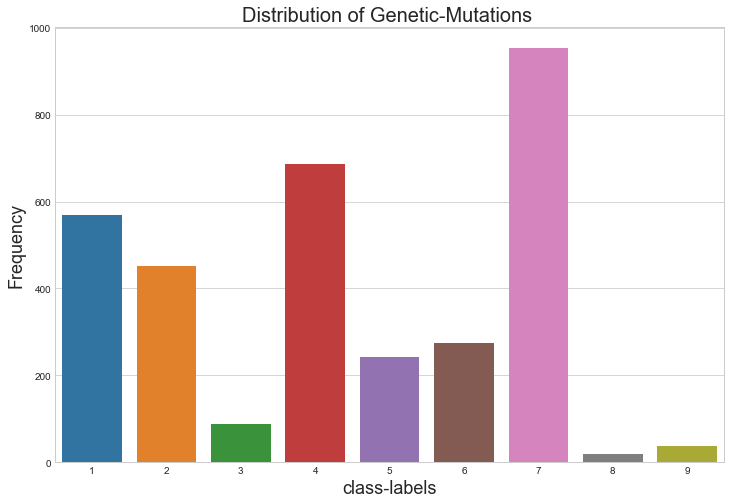

In [6]:
#getting the value counts of each-class
class_count = data["Class"].value_counts()
print(class_count)

#ploting the number of data-points for each genetic-mutation
plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.barplot(class_count.index , class_count.values)
plt.title("Distribution of Genetic-Mutations " ,fontsize =20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('class-labels', fontsize=18) 
plt.show()

### **Observations**
   
  * Clearly we can see dataset is imbalanced with some classes having majority

  * Class labels 3, 8, 9 has significantly low-frequency

  * Class labels 5, 6 has medium frequency

  * Class labels 1, 2, 4 has comparble high frequency

  * Class label 7 has the highest frequecy

 

In [7]:
#merging data
data_no_preprocess = pd.merge(data, data_text,on='ID', how='left')
data_no_preprocess.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


## 3.Text-Preprocessing

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        cleanhtml = re.compile('<.*?>')
        total_text = re.sub(cleanhtml,' ',total_text)
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
                
        data_text[column][index] = string      

In [9]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 118.4915008 seconds


In [10]:
#merging both gene_variations and text data based on ID
merge_data = pd.merge(data, data_text,on='ID', how='left')
merge_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
#checking for null-values
merge_data[merge_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [12]:
#replcaing null values
merge_data.loc[merge_data['TEXT'].isnull(),'TEXT'] = merge_data['Gene'] +' '+ merge_data['Variation']
merge_data[merge_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [13]:
#pre-processing gene and variation data
merge_data.Gene      = merge_data.Gene.str.replace('\s+', '_')
merge_data.Variation = merge_data.Variation.str.replace('\s+', '_')

## <h3> 4.Test, Train and Cross Validation Split</h3>

In [14]:
#splitting data into 64% train-20% test-16% CV data
y = merge_data["Class"].values
X = merge_data.drop(["Class"],axis=1)

X_train_cv,X_test ,y_train_cv ,y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 123,stratify = y )
X_train ,X_cv ,y_train ,y_cv = train_test_split (X_train_cv,y_train_cv,test_size = 0.2 , random_state = 123 )

In [15]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


##### 4.1 Distribution of classes in Train,Test and cross-validation data

For : Train-Data


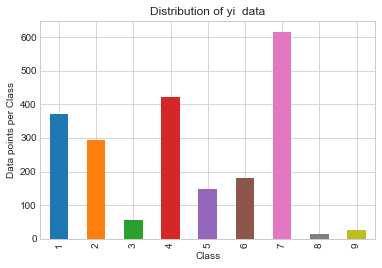

Number of data points in class 7 : 617 ( 29.049 %)
Number of data points in class 4 : 421 ( 19.821 %)
Number of data points in class 1 : 370 ( 17.42 %)
Number of data points in class 2 : 293 ( 13.795 %)
Number of data points in class 6 : 180 ( 8.475 %)
Number of data points in class 5 : 148 ( 6.968 %)
Number of data points in class 3 : 56 ( 2.637 %)
Number of data points in class 9 : 26 ( 1.224 %)
Number of data points in class 8 : 13 ( 0.612 %)
********************************************************************************************
For : Test-Data


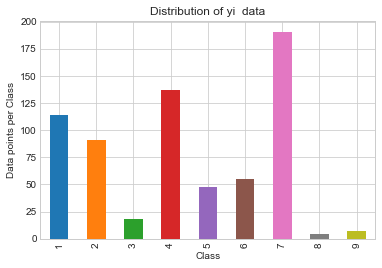

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
********************************************************************************************
For : Cross-Validation Data


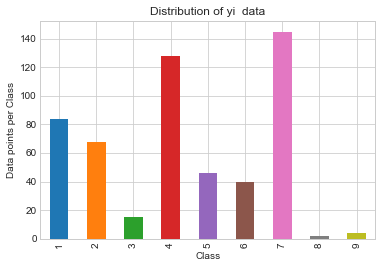

Number of data points in class 7 : 145 ( 27.256 %)
Number of data points in class 4 : 128 ( 24.06 %)
Number of data points in class 1 : 84 ( 15.789 %)
Number of data points in class 2 : 68 ( 12.782 %)
Number of data points in class 5 : 46 ( 8.647 %)
Number of data points in class 6 : 40 ( 7.519 %)
Number of data points in class 3 : 15 ( 2.82 %)
Number of data points in class 9 : 4 ( 0.752 %)
Number of data points in class 8 : 2 ( 0.376 %)
********************************************************************************************


In [16]:
#checking for distribution of each class 
train_classes =pd.Series( y_train).value_counts().sortlevel()
test_classes =pd.Series( y_test).value_counts().sortlevel()
cv_classes =pd.Series( y_cv).value_counts().sortlevel()


order_list = [0,1,2]
data_type = ["Train-Data","Test-Data" ,"Cross-Validation Data"]
data_list = [train_classes,test_classes,cv_classes]
y_list = [y_train,y_test,y_cv]

#ploting the ditribution
for i in order_list:
    my_colors = 'rgbkymc'
    data_list[i].plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi  data')
    print("For :" , data_type[i])
    plt.grid(True)
    plt.show()
    sorted_yi = np.argsort(-data_list[i].values)
    for m in sorted_yi:
        print('Number of data points in class', m+1, ':',data_list[i].values[m], 
          '(', np.round((data_list[i].values[m]/y_list[i].shape[0]*100), 3), '%)')

    print("********************************************************************************************")

### 5.Predicting Using a Random Model

Log loss on Cross Validation Data using Random Model 2.494908449118008
Log loss on Test Data using Random Model 2.473914578203381
-------------------- Confusion matrix --------------------


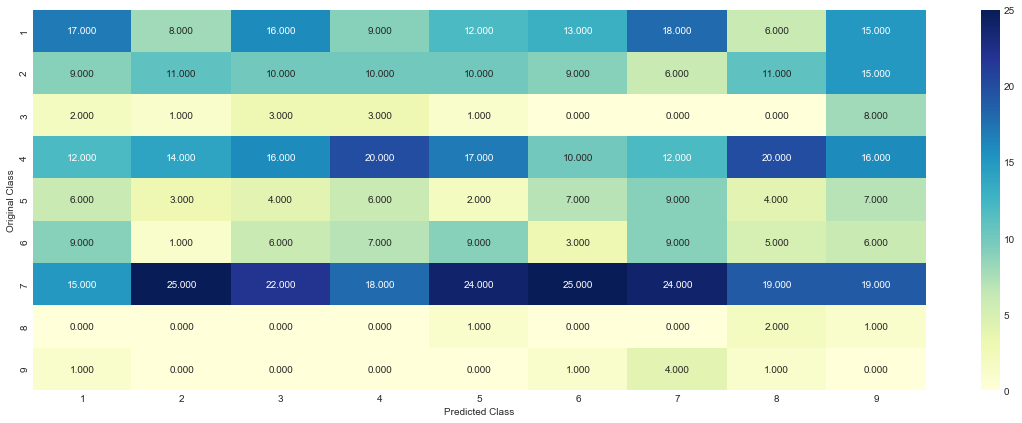

-------------------- Precision matrix (Columm Sum=1) --------------------


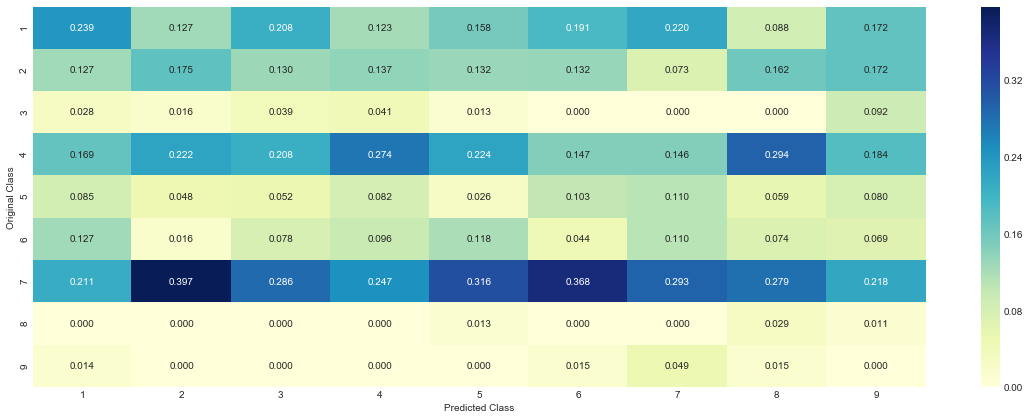

-------------------- Recall matrix (Row sum=1) --------------------


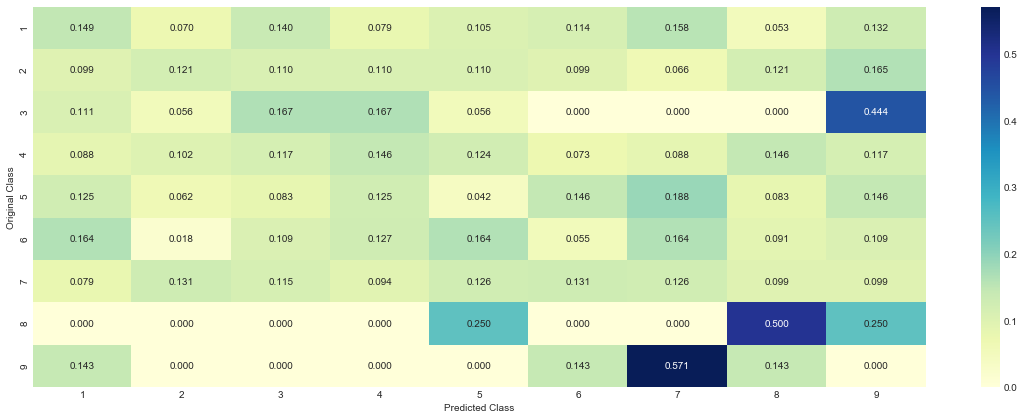

In [17]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
#computing cross-validation error
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-10))
log_loss_cv_rm =log_loss(y_cv,cv_predicted_y, eps=1e-10)


#computing test-error
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-10))
log_loss_test_rm = log_loss(y_test,test_predicted_y, eps=1e-10)


#ploting confusion,precision,recall matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)    
    

Observations:
    * A random model got log-loss around 2.5,so we need to build a model which gives log-loss less than 2.5 and that must be the case

## 6. Univariate Analysis

### 6.1 Univariate Analysis of Gene Feature which is categorical

In [18]:
#couting the frequency of each gene
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
BRCA1    171
TP53     101
EGFR      87
BRCA2     82
PTEN      82
KIT       64
BRAF      62
ALK       45
ERBB2     41
FLT3      38
Name: Gene, dtype: int64


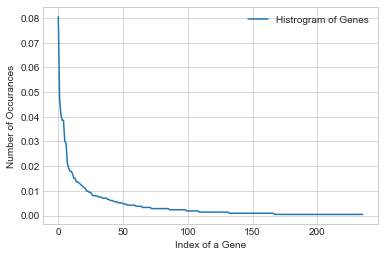

In [19]:
#ploting the distribution of Gene variable
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid(True)
plt.show()

##### Observations

* Very few genes have high occurences (about 50 out of 236 unique genes)
* Distribution of genes is a right skewed one

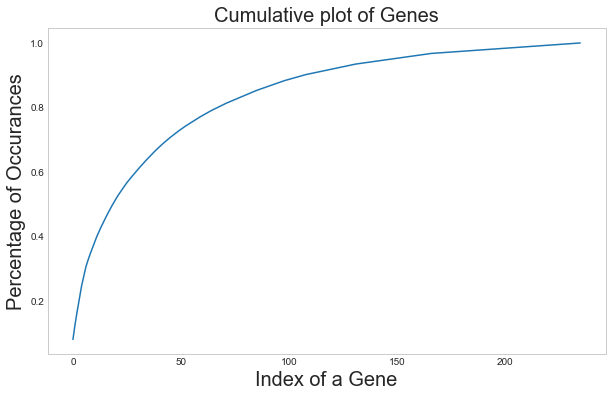

In [20]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(h))
plt.title("Cumulative plot of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Percentage of Occurances', fontsize = 20)
plt.grid()
plt.show()

##### Featurizing Gene Variable

* one-hot encoding (useful for logisitic-regression or SVM as they can handle high-dimensional data)
* Response-coding(useful for Random-forest and Decsion-tree as they can handle low-dimensional data well)

In [21]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

In [22]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:" , train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 235)


In [23]:
X_train['Gene'].head()

3186     NRAS
2814    BRCA2
1840    SETD2
2079     TET2
3049      KIT
Name: Gene, dtype: object

### 6.2 Checking whethter Gene Feature is important or not

For values of alpha =  1e-05 The log loss is: 1.4682808439246737
For values of alpha =  0.0001 The log loss is: 1.2785465186549798
For values of alpha =  0.001 The log loss is: 1.2647319207763883
For values of alpha =  0.01 The log loss is: 1.3413040622000858
For values of alpha =  0.1 The log loss is: 1.4362593194469782
For values of alpha =  1 The log loss is: 1.4709093733823442


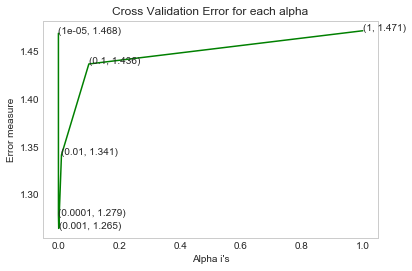

For values of best alpha =  0.001 The train log loss is: 1.0829654179364487
For values of best alpha =  0.001 The cross validation log loss is: 1.2647319207763883
For values of best alpha =  0.001 The test log loss is: 1.2622618733906243


In [24]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Observations:
    * Since the test and cross-validation log-loss is significantly close to train log-loss, Gene should be considered as important feature for prediction model

In [25]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 516 out of  532 : 96.99248120300751


##### Observations:
    * Gene feature is stable across the train,test and cross-validation datasets

### <h3>6.3 Univariate Analysis on Variation Feature</h3>

In [26]:
unique_variations = X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1925
Truncating_Mutations    52
Deletion                51
Amplification           46
Fusions                 23
G12V                     3
Overexpression           3
G13D                     2
G12C                     2
S308A                    2
Q209L                    2
Name: Variation, dtype: int64


In [27]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1925 different categories of variations in the train data, and they are distibuted as follows


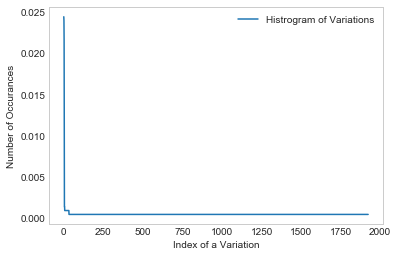

In [28]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02448211 0.04849341 0.07015066 ... 0.99905838 0.99952919 1.        ]


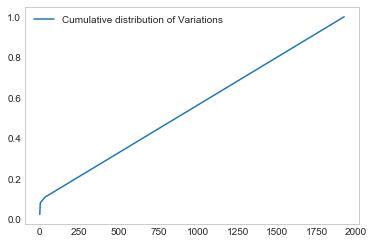

In [29]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [30]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [31]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1960)


For values of alpha =  1e-05 The log loss is: 1.693948500426924
For values of alpha =  0.0001 The log loss is: 1.684601821655645
For values of alpha =  0.001 The log loss is: 1.6880976102680285
For values of alpha =  0.01 The log loss is: 1.688392452073816
For values of alpha =  0.1 The log loss is: 1.699871240007007
For values of alpha =  1 The log loss is: 1.7025733917658608


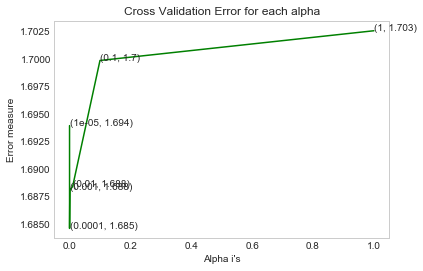

For values of best alpha =  0.0001 The train log loss is: 0.7542316587398102
For values of best alpha =  0.0001 The cross validation log loss is: 1.684601821655645
For values of best alpha =  0.0001 The test log loss is: 1.720721078218819


In [32]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Observations:
 * Since the log loss of test and cross-validation sets is not significantly differ from that of train log-loss,
 we would consider the vaiation feature to be important in training a predicting model

In [33]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q12. How many data points are covered by total  1925  genes in test and cross validation data sets?
Ans
1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 57 out of  532 : 10.714285714285714


##### Observations:
    * Variation feature is not stable acorss the train,test and cross-validation datasets

<h3>6.4 Univariate Analysis on Text Feature</h3>

In [34]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range = (1,2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 669014


In [35]:
#normalizing
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05 The log loss is: 1.5720816599089507
For values of alpha =  0.0001 The log loss is: 1.5682992377830354
For values of alpha =  0.001 The log loss is: 1.5226694437891164
For values of alpha =  0.01 The log loss is: 1.2668860771693868
For values of alpha =  0.1 The log loss is: 1.2752981288738405
For values of alpha =  1 The log loss is: 1.315814472943989


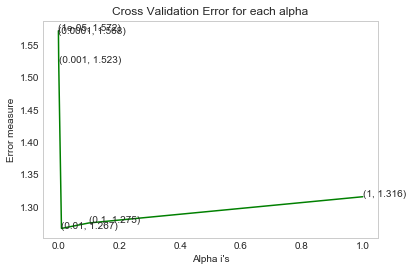

For values of best alpha =  0.01 The train log loss is: 0.8103588325809711
For values of best alpha =  0.01 The cross validation log loss is: 1.2668860771693868
For values of best alpha =  0.01 The test log loss is: 1.2388259434746751


In [36]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##### Observations:
 * Since the log loss of test and cross-validation sets is not significantly differ from that of train log-loss,
 we would consider the text feature to be important in training a predicting model

In [37]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3,ngram_range= (1,2))
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [38]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

92.357 % of word of test data appeared in train data
94.393 % of word of Cross Validation appeared in train data


## <h1>7. Machine Learning Models</h1>

#### 7.1 Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams

In [39]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [40]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv))

In [41]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 671209)
(number of data points * number of features) in test data =  (665, 671209)
(number of data points * number of features) in cross validation data = (532, 671209)


### 7.1.2 Logistic-Regression

for alpha = 1e-06
Log Loss : 1.5811038658327974
for alpha = 1e-05
Log Loss : 1.6044832114278227
for alpha = 0.0001
Log Loss : 1.58121456695481
for alpha = 0.001
Log Loss : 1.5074751869654892
for alpha = 0.01
Log Loss : 1.2334697152505552
for alpha = 0.1
Log Loss : 1.2404619493500157
for alpha = 1
Log Loss : 1.2894156547828315
for alpha = 10
Log Loss : 1.3281129970036287
for alpha = 100
Log Loss : 1.3358985244014667


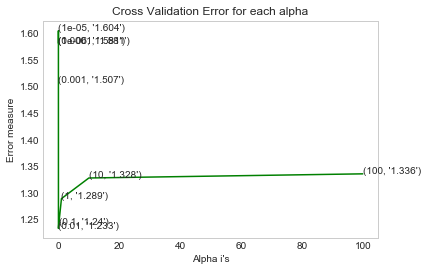

For values of best alpha =  0.01 The train log loss is: 0.7830378181780798
For values of best alpha =  0.01 The cross validation log loss is: 1.2334697152505552
For values of best alpha =  0.01 The test log loss is: 1.198656181435184


In [42]:
#applying logistic-regression
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2334697152505552
Number of mis-classified points : 0.42293233082706766
-------------------- Confusion matrix --------------------


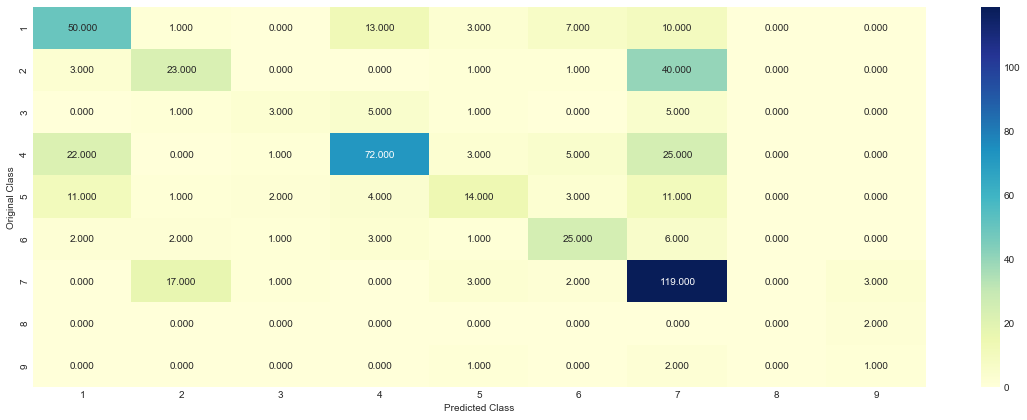

-------------------- Precision matrix (Columm Sum=1) --------------------


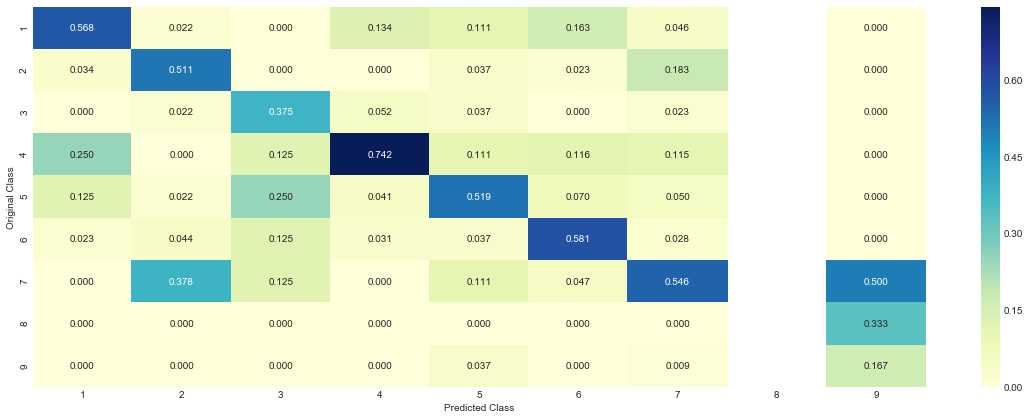

-------------------- Recall matrix (Row sum=1) --------------------


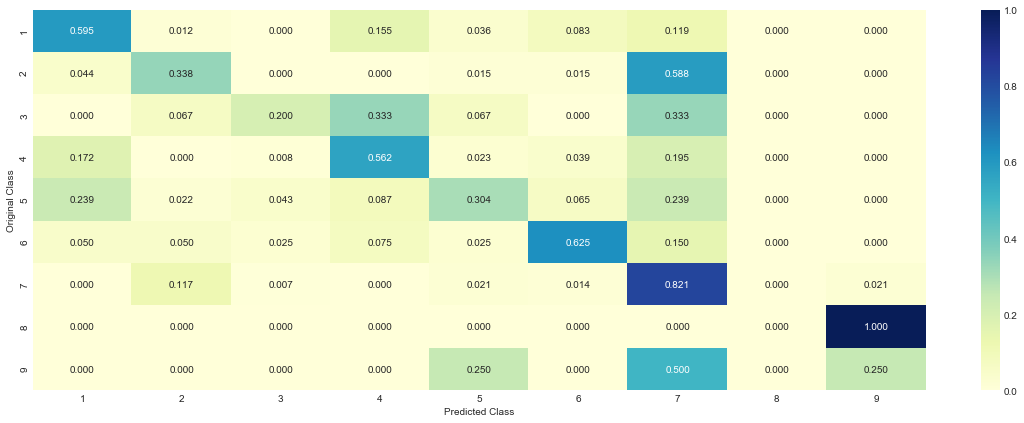

In [43]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [44]:
result = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"])

In [45]:
result = result.append(pd.DataFrame([["Logistic-Regression", 0.7830, 1.2334, 1.1986, "42.29%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

## Conclusions:

In [46]:
result

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Remarks
0,Logistic-Regression,0.783,1.2334,1.1986,42.29%,GoodFit


## 8. All the models with top-1000 tfidf features

In [47]:
result1 = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"])

In [48]:
#initializing tfidfvectorizer 
gene_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2' ,max_features = 1000)
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])


# tfidf of variation feature.
variation_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2' ,max_features = 1000)
train_variation_feature_tfidf= variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_tfidf = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_tfidf = variation_vectorizer.transform(X_cv['Variation'])

# building a tfidf with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2' ,max_features = 1000,min_df =5)
train_text_feature_tfidf = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

print("Total number of unique words in train data :", len(train_text_features))


#normalizing
train_text_feature_tfidf1 = normalize(train_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidf = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidf1 = normalize(test_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidf = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidf1= normalize(cv_text_feature_tfidf, axis=0)

Total number of unique words in train data : 1000


In [49]:
train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_variation_feature_tfidf))

train_x_tfidf= hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(y_train))

test_x_tfidf= hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(y_test))

cv_x_tfidf = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(y_cv))

In [50]:
print("TFIDF features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

TFIDF features :
(number of data points * number of features) in train data =  (2124, 2235)
(number of data points * number of features) in test data =  (665, 2235)
(number of data points * number of features) in cross validation data = (532, 2235)


## 8.1 Naive-Bayes

for alpha = 1e-05
Log Loss : 1.2259562051248456
for alpha = 0.0001
Log Loss : 1.226492949623155
for alpha = 0.001
Log Loss : 1.226514211352827
for alpha = 0.1
Log Loss : 1.2100441935748834
for alpha = 1
Log Loss : 1.193621043532439
for alpha = 10
Log Loss : 1.243901686579564
for alpha = 100
Log Loss : 1.3015489413532364
for alpha = 1000
Log Loss : 1.3118654556444598


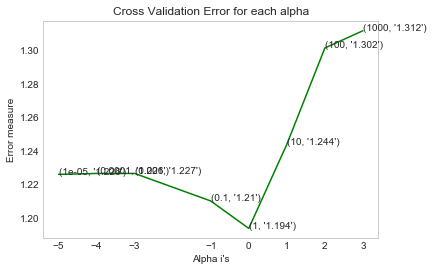

For values of best alpha =  1 The train log loss is: 0.9870291992844077
For values of best alpha =  1 The cross validation log loss is: 1.193621043532439
For values of best alpha =  1 The test log loss is: 1.240300891021964


In [51]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.193621043532439
Number of mis-classified points : 0.40601503759398494
-------------------- Confusion matrix --------------------


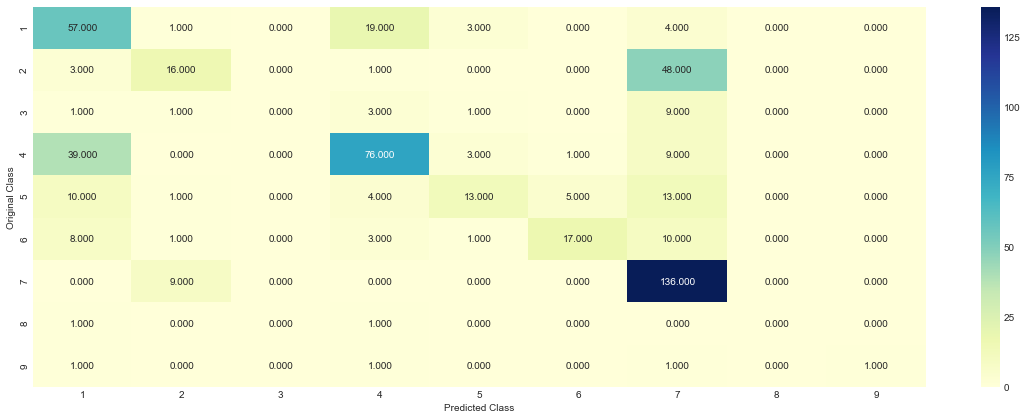

-------------------- Precision matrix (Columm Sum=1) --------------------


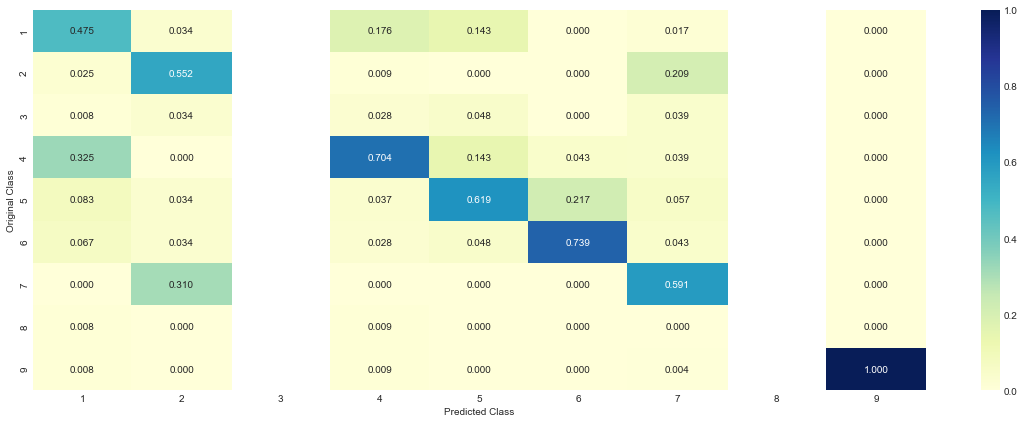

-------------------- Recall matrix (Row sum=1) --------------------


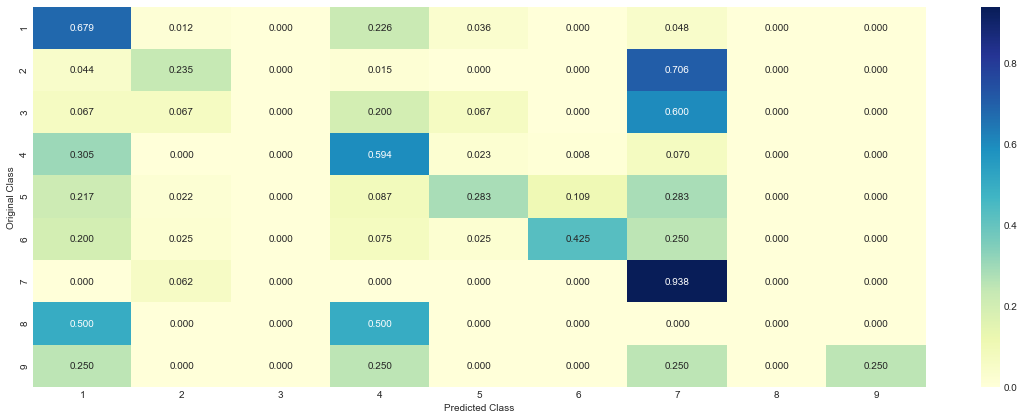

In [52]:
#ploting confusion matrix
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

In [53]:
result1 = result1.append(pd.DataFrame([["Naive-Bayes", 0.9870, 1.1936, 1.2304, "40.60%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

## 8.2 K-NN

for alpha = 5
Log Loss : 1.218793620786283
for alpha = 11
Log Loss : 1.2037074985017382
for alpha = 15
Log Loss : 1.2084481253899635
for alpha = 21
Log Loss : 1.2019297766335362
for alpha = 31
Log Loss : 1.2239934355413786
for alpha = 41
Log Loss : 1.227838103057969
for alpha = 51
Log Loss : 1.2322283993592864
for alpha = 99
Log Loss : 1.2728343366145283


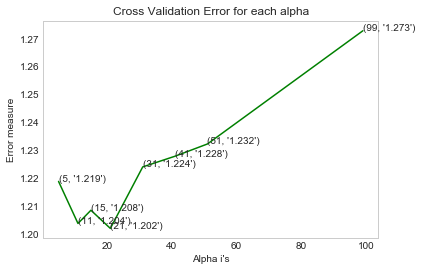

For values of best alpha =  21 The train log loss is: 1.1171396324732938
For values of best alpha =  21 The cross validation log loss is: 1.2019297766335362
For values of best alpha =  21 The test log loss is: 1.2438097768275247


In [54]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.2019297766335362
Number of mis-classified points : 0.424812030075188
-------------------- Confusion matrix --------------------


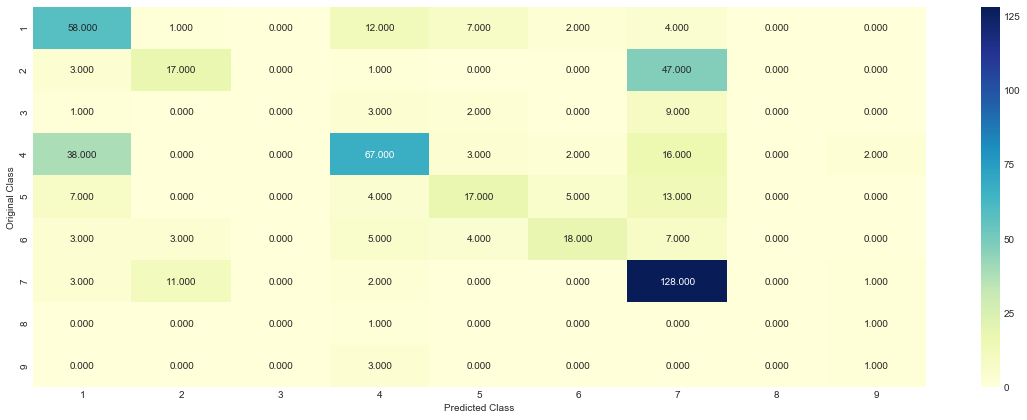

-------------------- Precision matrix (Columm Sum=1) --------------------


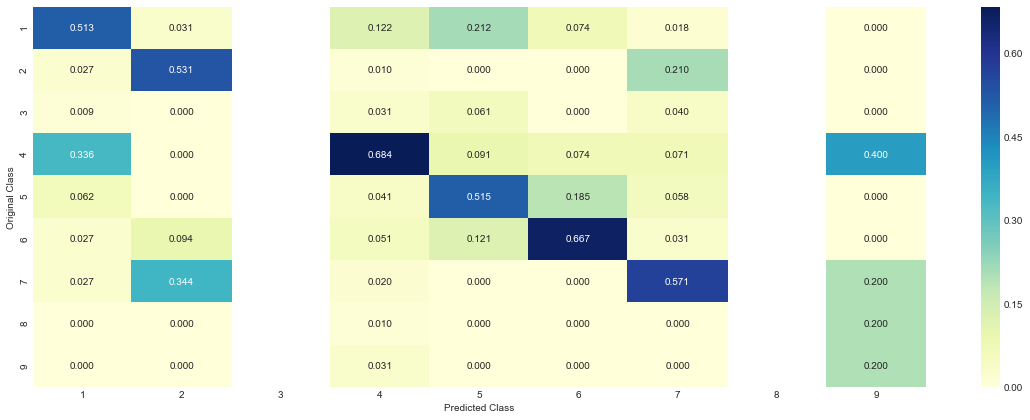

-------------------- Recall matrix (Row sum=1) --------------------


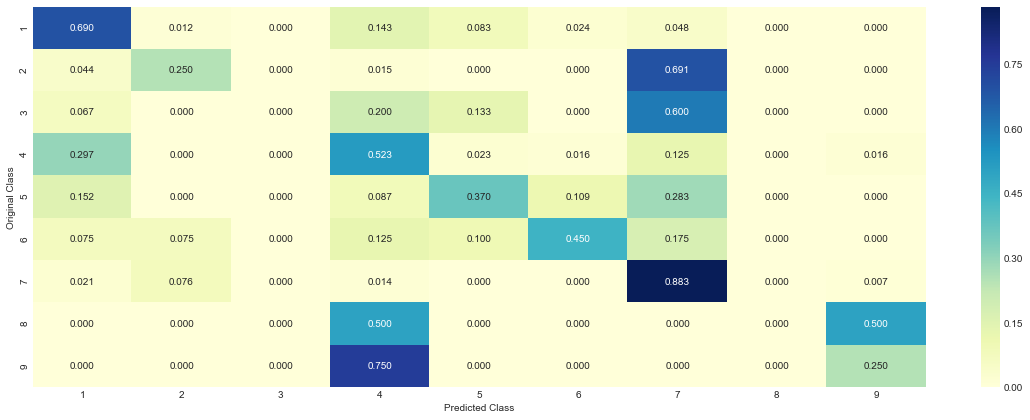

In [55]:
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

In [56]:
result1 = result1.append(pd.DataFrame([["K-NN", 1.1171, 1.2019, 1.2438, "42.48%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

## <h2>8.3 Logistic Regression</h2>

for alpha = 1e-06
Log Loss : 1.2465364219282533
for alpha = 1e-05
Log Loss : 1.2201730586306971
for alpha = 0.0001
Log Loss : 1.065528182075855
for alpha = 0.001
Log Loss : 1.0716527120866841
for alpha = 0.01
Log Loss : 1.2203815235147992
for alpha = 0.1
Log Loss : 1.4792062606778265
for alpha = 1
Log Loss : 1.5796221907695527
for alpha = 10
Log Loss : 1.5925190888839187
for alpha = 100
Log Loss : 1.5939764196845596


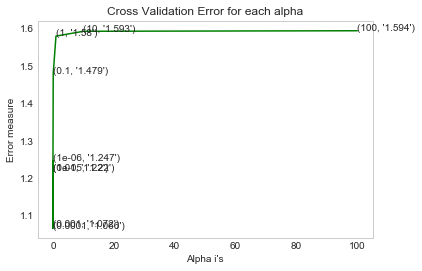

For values of best alpha =  0.0001 The train log loss is: 0.6123928658234737
For values of best alpha =  0.0001 The cross validation log loss is: 1.065528182075855
For values of best alpha =  0.0001 The test log loss is: 1.071597764315154


In [57]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.065528182075855
Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


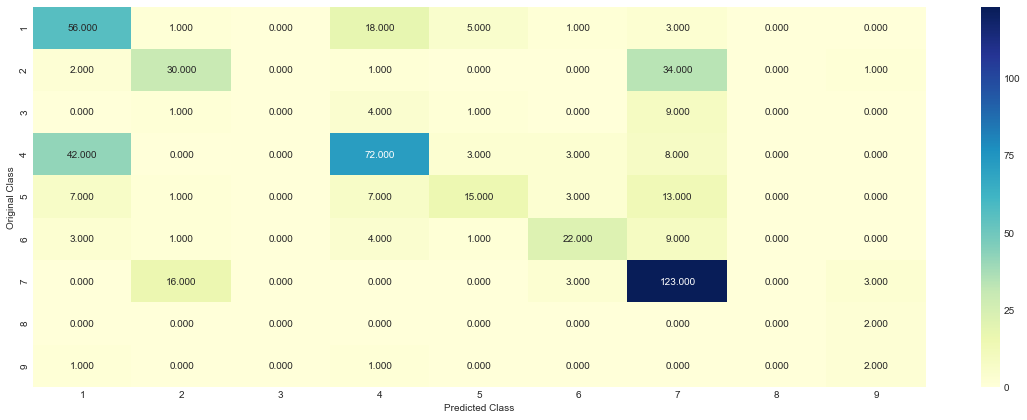

-------------------- Precision matrix (Columm Sum=1) --------------------


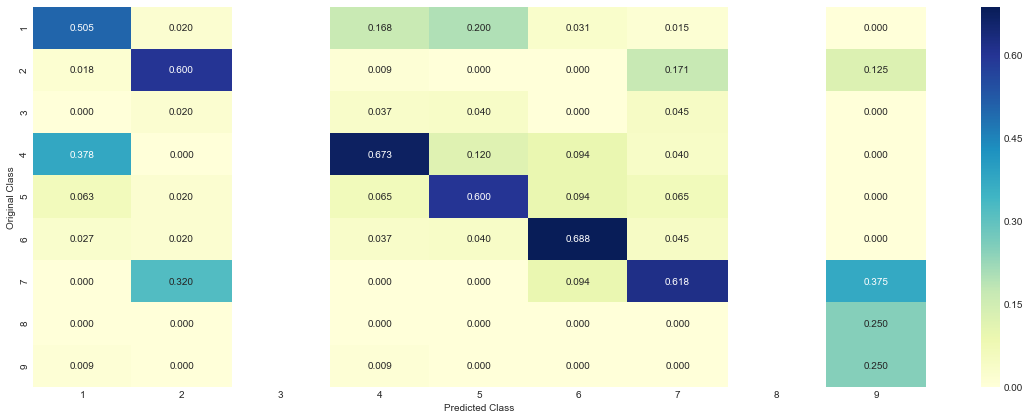

-------------------- Recall matrix (Row sum=1) --------------------


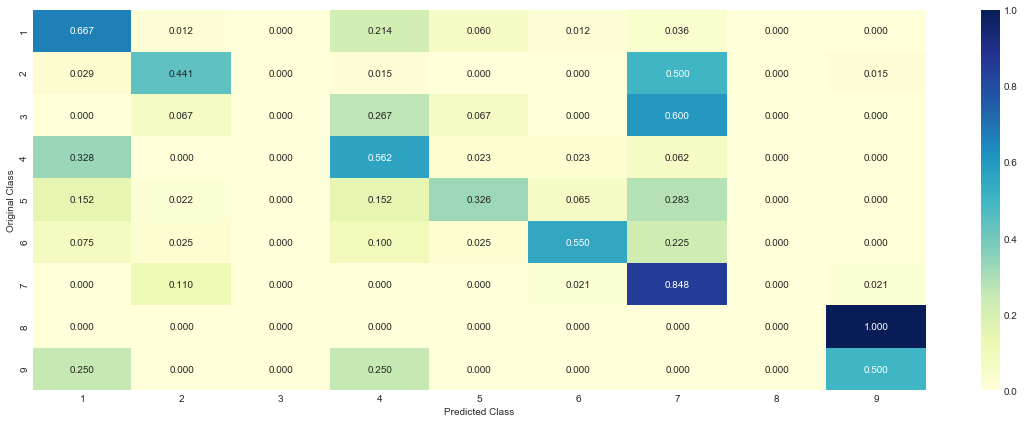

In [58]:
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

In [59]:
result1 = result1.append(pd.DataFrame([["Logistic-Regression",0.6123, 1.0655, 1.0715, "39.84%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

<h2>8.4  Linear Support Vector Machines</h2>

for C = 1e-05
Log Loss : 1.2160797388003899
for C = 0.0001
Log Loss : 1.1797621743575233
for C = 0.001
Log Loss : 1.2091867797280327
for C = 0.01
Log Loss : 1.3156285445438407
for C = 0.1
Log Loss : 1.5426932155396316
for C = 1
Log Loss : 1.594298631721724
for C = 10
Log Loss : 1.5942985842074928
for C = 100
Log Loss : 1.5942986294512307


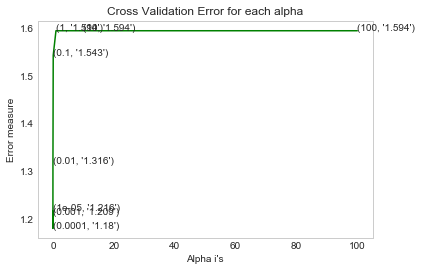

For values of best alpha =  0.0001 The train log loss is: 0.718759251019382
For values of best alpha =  0.0001 The cross validation log loss is: 1.1797621743575233
For values of best alpha =  0.0001 The test log loss is: 1.1754326810083873


In [60]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1797621743575233
Number of mis-classified points : 0.41353383458646614
-------------------- Confusion matrix --------------------


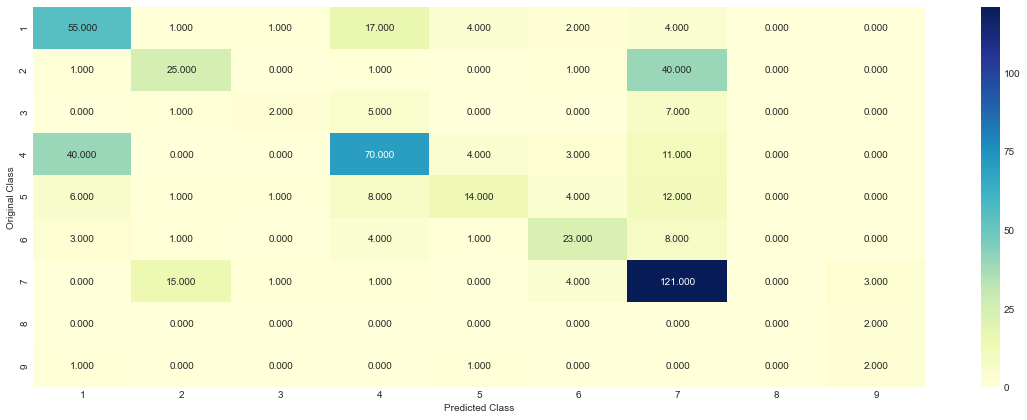

-------------------- Precision matrix (Columm Sum=1) --------------------


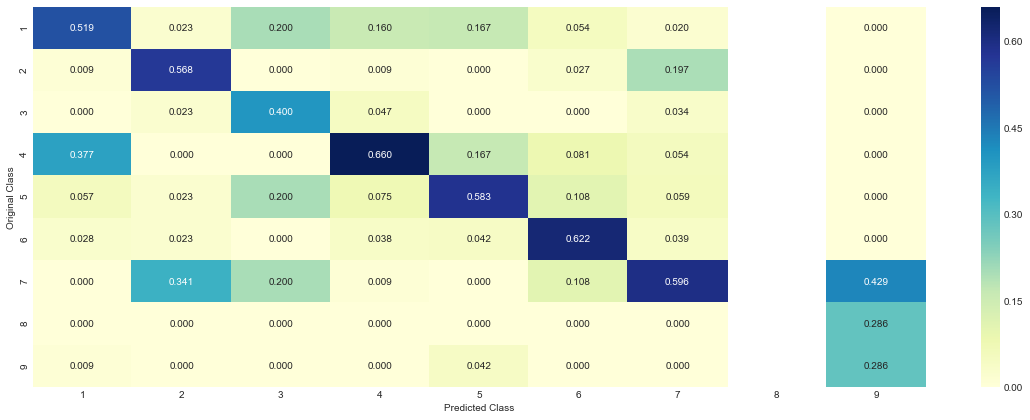

-------------------- Recall matrix (Row sum=1) --------------------


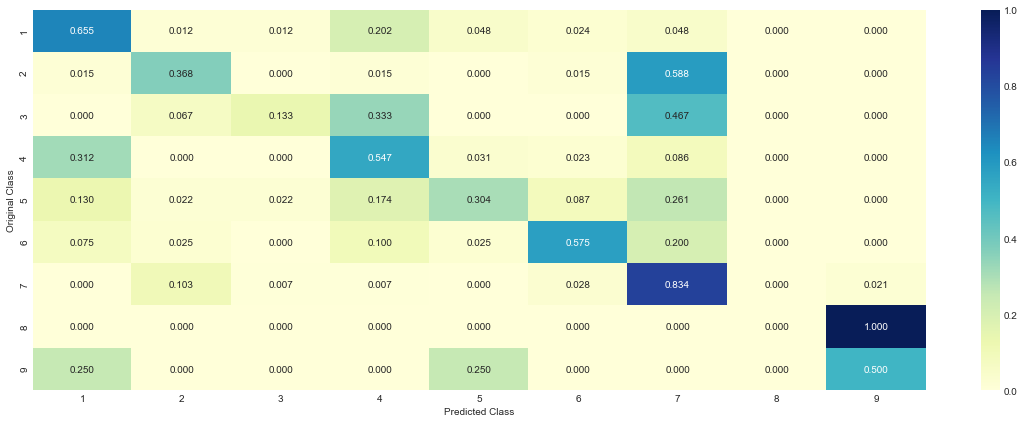

In [61]:
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

In [62]:
result1 = result1.append(pd.DataFrame([["Linear-SVM", 0.7187, 1.1797, 1.1754, "41.35%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

<h2> 8.5 Random Forest Classifier</h2>

In [63]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1215962772043093
for n_estimators = 100 and max depth =  10
Log Loss : 1.1304681961756393
for n_estimators = 200 and max depth =  5
Log Loss : 1.1193874277647333
for n_estimators = 200 and max depth =  10
Log Loss : 1.1198270324301776
for n_estimators = 500 and max depth =  5
Log Loss : 1.123549800737744
for n_estimators = 500 and max depth =  10
Log Loss : 1.1160243335958873
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1185785179998853
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1121676779838399
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1185803217258512
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1130772557334192
For values of best estimator =  1000 The train log loss is: 0.5580987476285331
For values of best estimator =  1000 The cross validation log loss is: 1.1121676779838399
For values of best estimator =  1000 The test log loss is: 1.1063957192253842


Log loss : 1.1121676779838399
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


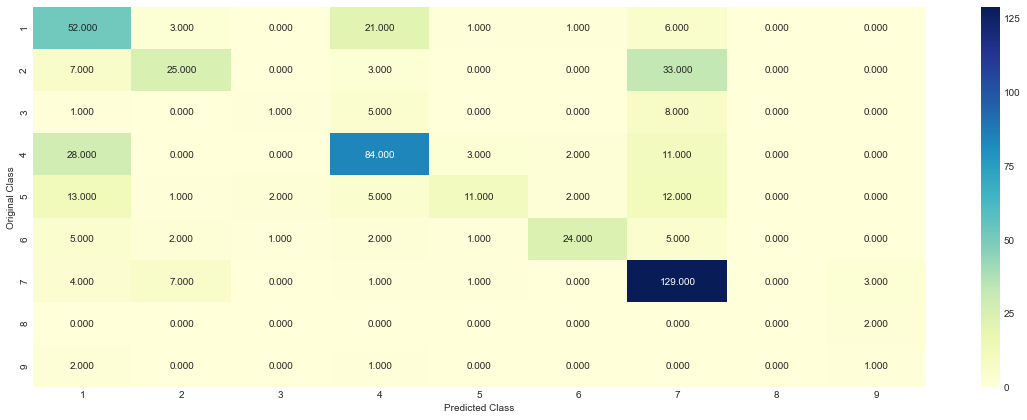

-------------------- Precision matrix (Columm Sum=1) --------------------


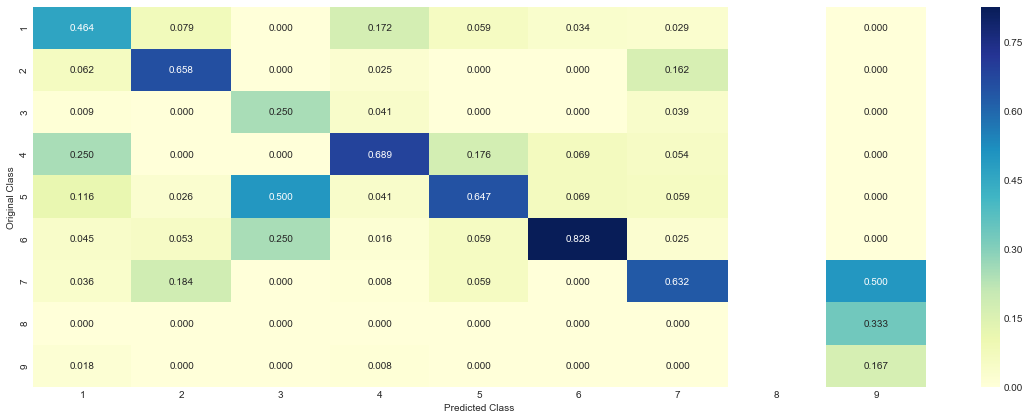

-------------------- Recall matrix (Row sum=1) --------------------


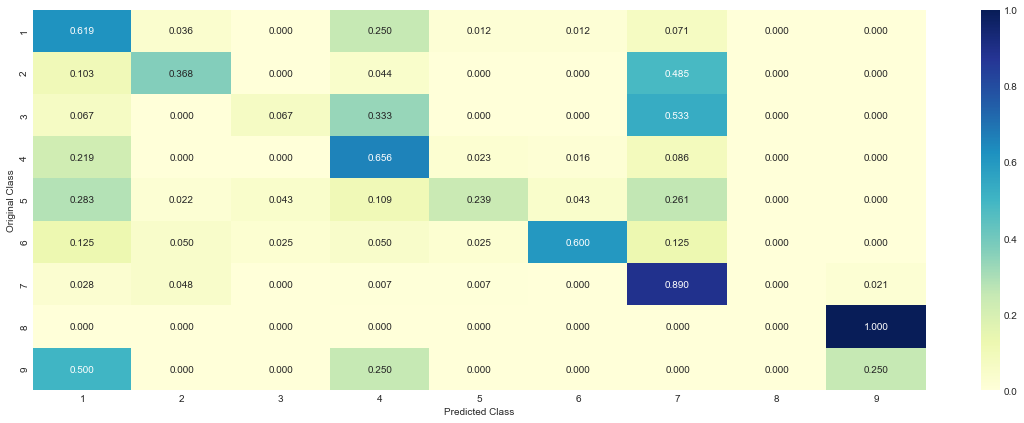

In [64]:
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

In [65]:
result1 = result1.append(pd.DataFrame([["Random-Forest",0.5580, 1.1121, 1.1063, "38.53%",  "BestFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

<h2>8.6 Stack the models </h2>

In [66]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tfidf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tfidf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tfidf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_tfidf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tfidf))))
sig_clf2.fit(train_x_tfidf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tfidf))))
sig_clf3.fit(train_x_tfidf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tfidf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.59
Naive Bayes : Log Loss: 1.23
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.048
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.568
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.176
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.163
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.201


<h3>testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.8166620953107279
Log loss (CV) on the stacking classifier : 1.1756872281645971
Log loss (test) on the stacking classifier : 1.19587295751898
Number of missclassified point : 0.3924812030075188
-------------------- Confusion matrix --------------------


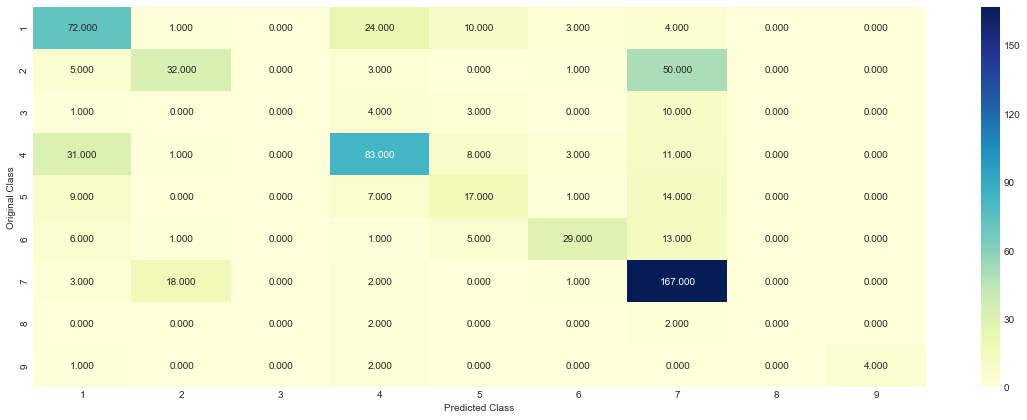

-------------------- Precision matrix (Columm Sum=1) --------------------


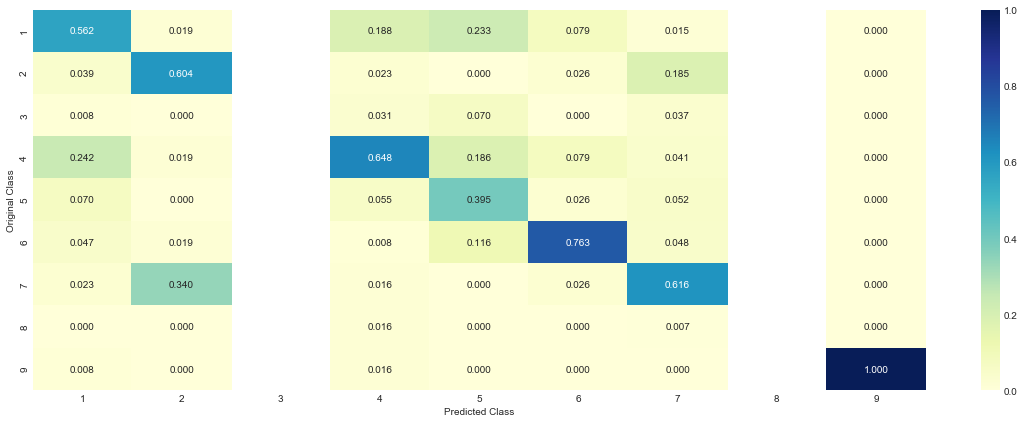

-------------------- Recall matrix (Row sum=1) --------------------


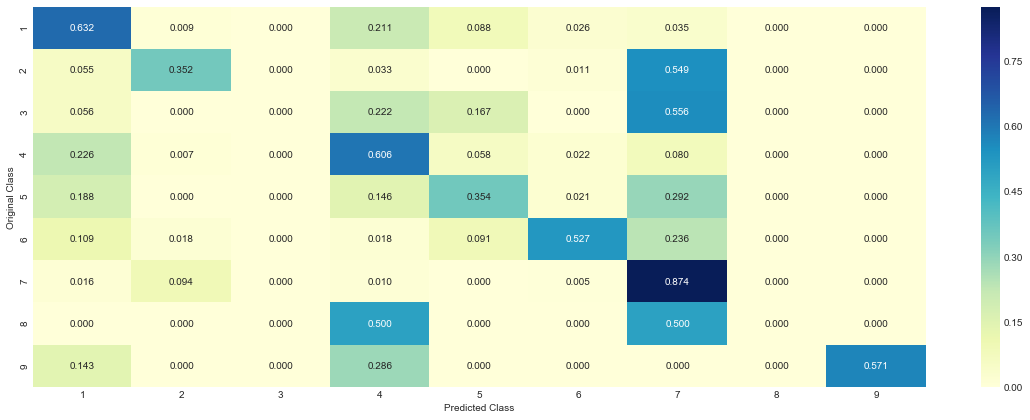

In [67]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_tfidf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tfidf))

In [68]:
result1 = result1.append(pd.DataFrame([["stacking-classifier",0.8166,1.1756, 1.1958, "39.24%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

<h3>8.7 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.9406402937098679
Log loss (CV) on the VotingClassifier : 1.2165903525810051
Log loss (test) on the VotingClassifier : 1.2421220869729934
Number of missclassified point : 0.38646616541353385
-------------------- Confusion matrix --------------------


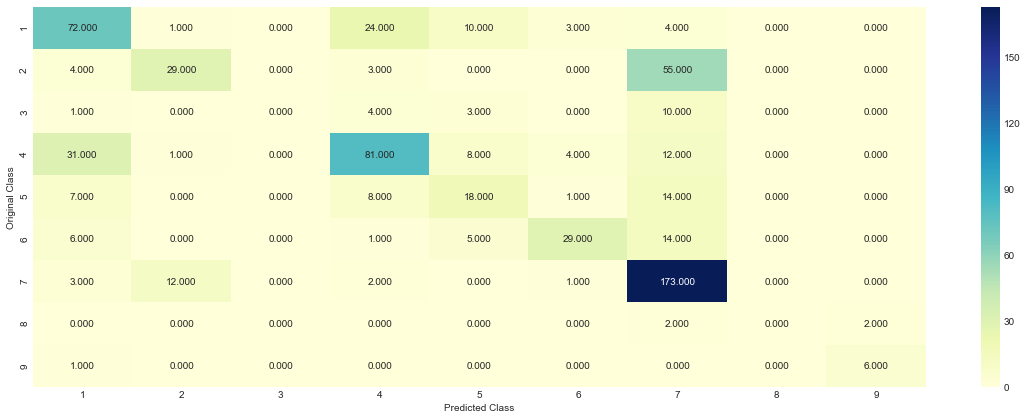

-------------------- Precision matrix (Columm Sum=1) --------------------


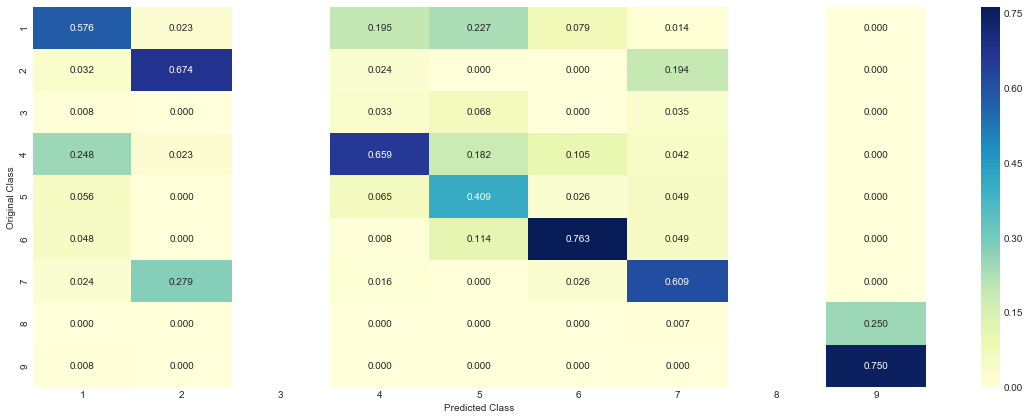

-------------------- Recall matrix (Row sum=1) --------------------


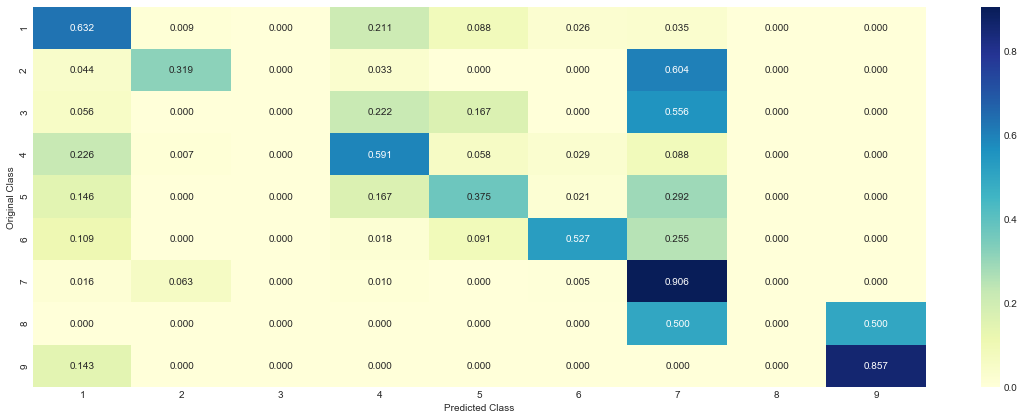

In [69]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_tfidf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf))

In [70]:
result1 = result1.append(pd.DataFrame([["Maximum voting classifier",0.9406, 1.2165, 1.2421, "38.64%",  "GoodFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

## Conclusions:

In [71]:
(result1)

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Remarks
0,Naive-Bayes,0.9870,1.1936,1.2304,40.60%,GoodFit
0,K-NN,1.1171,1.2019,1.2438,42.48%,GoodFit
0,Logistic-Regression,0.6123,1.0655,1.0715,39.84%,GoodFit
0,Linear-SVM,0.7187,1.1797,1.1754,41.35%,GoodFit
0,Random-Forest,0.5580,1.1121,1.1063,38.53%,BestFit
0,stacking-classifier,0.8166,1.1756,1.1958,39.24%,GoodFit
0,Maximum voting classifier,0.9406,1.2165,1.2421,38.64%,GoodFit


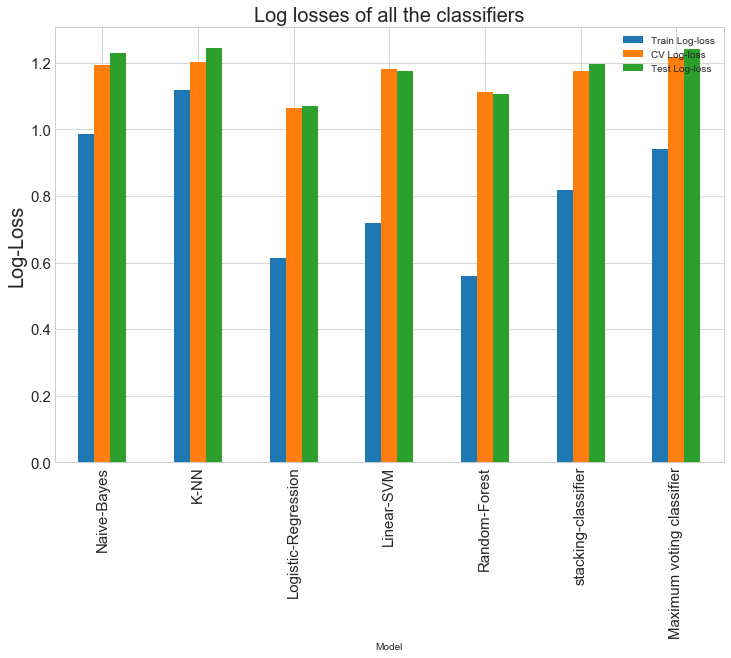

In [72]:
result2 = result1.drop(["Mis-Classified CV", "Remarks"], axis = 1)
result2.plot(x = "Model", kind = "bar", figsize = (12, 8), grid = True, fontsize = 15)
plt.title("Log losses of all the classifiers", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [73]:
#getting the data
data_no_preprocess.head(5)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv))

In [75]:
#importing required libraries
import re

#pre-defined finctions to remove html tags ,punctuations, special characters

#function fro removing html tags
def remove_html (sentence):
    cleanhtml = re.compile('<.*?>')
    clean_text = re.sub(cleanhtml,' ',str(sentence))
    return clean_text

#function for removing punctuations and special characters
def remove_punc(sentence):
    cleanpunc = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleanpunc = re.sub(r'[.|,|)|(|\|/]',r' ',cleanpunc)
    cleanpunc = cleanpunc.strip()
    cleanpunc = cleanpunc.replace("\n" ,'')
    return cleanpunc
    
    
#function for keeping only alphabets
def keep_alpha(sentence):
    alpha_sentence = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sentence += alpha_word
        alpha_sentence += " "
    alpha_sentence = alpha_sentence.strip()
    return alpha_sentence



#removing stopwords with some exceptions and do stemmming
#initializing stopwords with some exceptions words like not and very and stemming 
import nltk
#nltk.download("stopwords")

from nltk.corpus import stopwords

exceptions = set(("very","not","few","against","more" ,"between",))

stop_words = set(stopwords.words('english')) - exceptions
stop_words.update(['zero','one','two','three','four','five','six','seven','eight',
                   'nine','ten','may','also','however','yet'])
print(stop_words)

#function for removing stopwords

def remove_stopwords(sentence):
    no_stopword_review = ""
    for word in sentence.split():
        if word not in stop_words:
            no_stopword_review += word
            no_stopword_review += " "
    no_stopword_review = no_stopword_review.strip()
    return no_stopword_review


#stemming
sno = nltk.stem.SnowballStemmer('english')

#function to do stemming
def stem_remove(sentence):
    stem_sentence = ""
    for word in sentence.split():
        stem_word = sno.stem(word)
        stem_sentence += stem_word
        stem_sentence += " "
    stem_sentence = stem_sentence.strip()
    return stem_sentence

{'couldn', 'mustn', 'themselves', 'hasn', 'shan', "mustn't", "weren't", 'hadn', "hadn't", 're', 'were', 'an', 'again', 'are', 'yourself', 'who', 'herself', 'hers', "should've", 'here', 'ourselves', "you'll", 'out', 've', 'be', 'can', "you're", 'she', "haven't", 'during', 'her', 'above', "couldn't", 'ain', 'as', 't', 'at', 'through', 'ours', 'a', 'theirs', 'its', 'that', 'you', 'do', 'why', "mightn't", 'same', "doesn't", "that'll", 'how', 'down', 'should', 'after', 'whom', 'further', 'some', 'but', 'before', 'eight', 'other', 'doesn', 'he', 'itself', 'in', "don't", 'their', "didn't", 'no', 'am', 'than', 'weren', 'under', 'yourselves', "wouldn't", 'was', 'being', 'when', "wasn't", 'isn', 'on', 'however', 'it', 'this', 'there', 'only', 'me', 'or', 'because', "hasn't", 'wouldn', 'four', 'may', 'zero', 'too', 'of', 'where', 'into', 'own', 'about', 'needn', 'what', 'nine', 'once', "aren't", 'has', 'my', 'them', 'did', 'won', 'your', 'from', 'wasn', "she's", 'aren', 'is', 'll', 'ten', 'yet', 

In [77]:
#applying all pre-processing functions on the text to get cleaned text
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].str.lower()
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].apply(remove_html)
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].apply(remove_punc)
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].apply(keep_alpha)
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].apply(remove_stopwords)
data_no_preprocess['TEXT'] = data_no_preprocess['TEXT'].apply(stem_remove)

## AvgW2Vec

In [79]:
#importing required libraries
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec

#spliting the text review into sentences
list_of_sentences=[]
for sent in data_no_preprocess['TEXT'].values:
    list_of_sentences.append(sent.split())
    
#initiating word2vec with required parameters like minimum count for any word to be considered
word2vec_model = Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)
word2vec_words = list(word2vec_model.wv.vocab)

#getting avgw2vec  for each review
avgw2vec_vectors = []; #list of avgw2vec vectors
for sent in list_of_sentences: 
    sent_vectors = np.zeros(50) 
    count_words =0; 
    for word in sent: 
        if word in word2vec_words:
            vec = word2vec_model.wv[word]
            sent_vectors += vec
            count_words += 1 #number of words in the sentence vector
    if count_words != 0:
        sent_vectors /= count_words #taking the average
    avgw2vec_vectors.append(sent_vectors)

In [80]:
#splitting data into 64% train-20% test-16% CV data
y = merge_data["Class"].values
X = avgw2vec_vectors 

X_train_cv,X_test ,y_train_cv ,y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 123,stratify = y )
X_train ,X_cv ,y_train ,y_cv = train_test_split (X_train_cv,y_train_cv,test_size = 0.2 , random_state = 123 )

In [81]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x = hstack((train_gene_var_onehotCoding, X_train)).tocsr()
train_y = np.array(list(y_train))

test_x = hstack((test_gene_var_onehotCoding, X_test)).tocsr()
test_y = np.array(list(y_test))

cv_x = hstack((cv_gene_var_onehotCoding,X_cv)).tocsr()
cv_y = np.array(list(y_cv))

## Random-Forest

In [88]:
esti = [10,20,30,40,50,80,100]
max_depth = [5, 10,15,20]
cv_log_error_array = []
for i in esti:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 10 and max depth =  5
Log Loss : 1.2935362160633879
for n_estimators = 10 and max depth =  10
Log Loss : 1.1589219508159014
for n_estimators = 10 and max depth =  15
Log Loss : 1.1701017900217459
for n_estimators = 10 and max depth =  20
Log Loss : 1.1611010916058804
for n_estimators = 20 and max depth =  5
Log Loss : 1.2492523025714375
for n_estimators = 20 and max depth =  10
Log Loss : 1.1383195752780166
for n_estimators = 20 and max depth =  15
Log Loss : 1.1365768663376945
for n_estimators = 20 and max depth =  20
Log Loss : 1.1424313966094788
for n_estimators = 30 and max depth =  5
Log Loss : 1.2252174721176432
for n_estimators = 30 and max depth =  10
Log Loss : 1.13331450689948
for n_estimators = 30 and max depth =  15
Log Loss : 1.1257953350723306
for n_estimators = 30 and max depth =  20
Log Loss : 1.1294379760171616
for n_estimators = 40 and max depth =  5
Log Loss : 1.216923135607606
for n_estimators = 40 and max depth =  10
Log Loss : 1.1266039470444331

In [91]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=15, random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print( "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print( "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The train log loss is: 0.5241995297319304
The cross validation log loss is: 1.102602844779191
The test log loss is: 1.1068232673038858


Log loss : 1.102602844779191
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


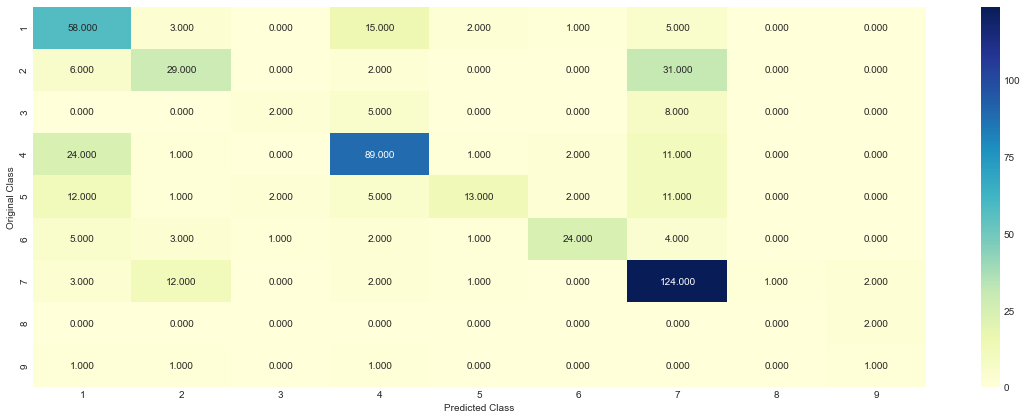

-------------------- Precision matrix (Columm Sum=1) --------------------


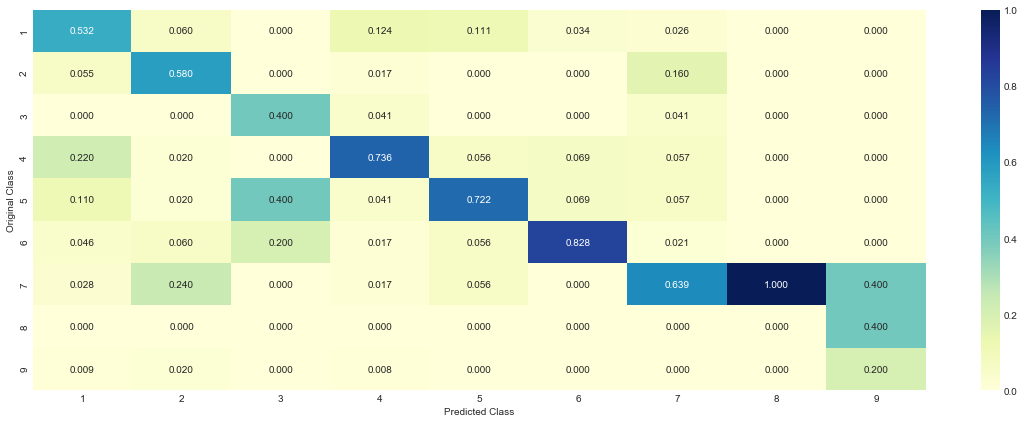

-------------------- Recall matrix (Row sum=1) --------------------


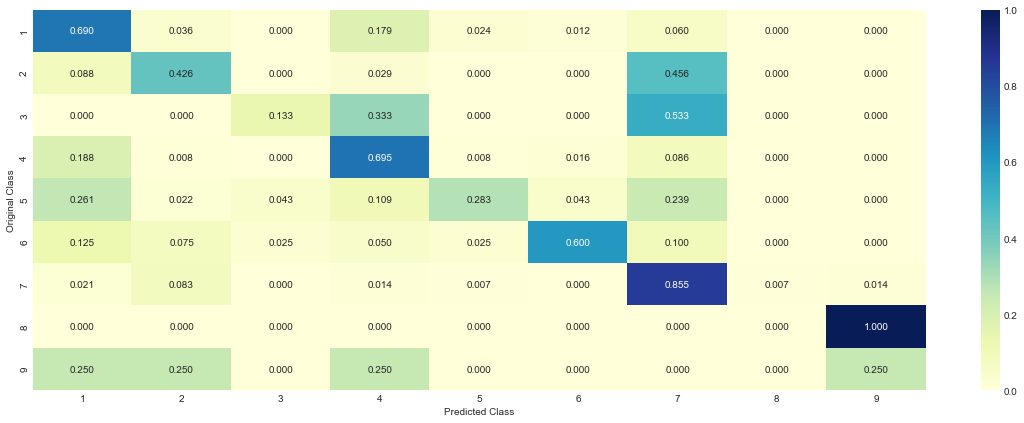

In [92]:
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

In [95]:
result2 = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"])
result2 = result2.append(pd.DataFrame([["Random-Forest",0.5241, 1.1026, 1.1068, "36.09%",  "BestFit"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Remarks"]))

In [96]:
result2

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Remarks
0,Random-Forest,0.5241,1.1026,1.1068,36.09%,BestFit
